In [ ]:
!pip install numba-cuda[12]

Time taken : 0.07765340805053711 sec


array([[[50, 50, 50],
        [50, 50, 50],
        [50, 50, 50],
        ...,
        [95, 95, 95],
        [95, 95, 95],
        [95, 95, 95]],

       [[50, 50, 50],
        [50, 50, 50],
        [50, 50, 50],
        ...,
        [95, 95, 95],
        [95, 95, 95],
        [95, 95, 95]],

       [[50, 50, 50],
        [50, 50, 50],
        [50, 50, 50],
        ...,
        [95, 95, 95],
        [95, 95, 95],
        [95, 95, 95]],

       ...,

       [[51, 51, 51],
        [52, 52, 52],
        [53, 53, 53],
        ...,
        [55, 55, 55],
        [55, 55, 55],
        [55, 55, 55]],

       [[54, 54, 54],
        [54, 54, 54],
        [54, 54, 54],
        ...,
        [55, 55, 55],
        [55, 55, 55],
        [55, 55, 55]],

       [[55, 55, 55],
        [55, 55, 55],
        [55, 55, 55],
        ...,
        [55, 55, 55],
        [55, 55, 55],
        [55, 55, 55]]], dtype=uint8)
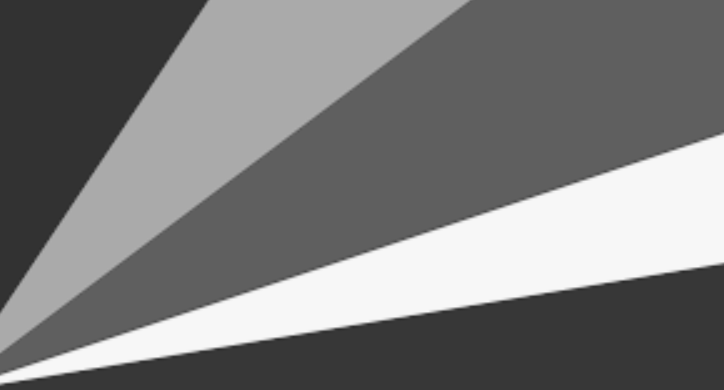

In [ ]:
##### GPU #####

from PIL import Image
import time
from IPython.display import display
from numba import cuda
import numpy as np
from numba import config
config.CUDA_ENABLE_PYNVJITLINK = 1

# Function to convert in a grey image
@cuda.jit   # For GPU
def greyscale_gpu(src, dst):
    tidx = cuda.grid(1)
    if tidx < src.shape[0]: # Image limit
        r = src[tidx, 0]
        g = src[tidx, 1]
        b = src[tidx, 2]
        gy = np.uint8((r + g + b) / 3)  # Average of pixels
        dst[tidx, 0] = gy
        dst[tidx, 1] = gy
        dst[tidx, 2] = gy # The 3 pixels become grey

start_time = time.time() # Timer

img = Image.open("/content/image.PNG").convert("RGB") # Load image
rgb_array = np.array(img, dtype=np.uint8)
h, w, c = rgb_array.shape
pixelCount = h * w
flat_img = rgb_array.reshape(pixelCount, 3) # 1D array

grey_array = np.zeros_like(flat_img) # Allocate space for result

threads_per_block = 256
blocks = (pixelCount + threads_per_block - 1) // threads_per_block  # divide the image

d_src = cuda.to_device(flat_img)   # Input
d_dst = cuda.device_array_like(flat_img)  # Output
greyscale_gpu[blocks, threads_per_block](d_src, d_dst) # Function for greyscaling
cuda.synchronize()
hostDst = d_dst.copy_to_host() # GPU -> CPU
grey_img = hostDst.reshape((h,w,3))  # 1D -> 2D

end_time = time.time()  # Timer
print(f"Time taken : {end_time - start_time} sec")

display(grey_img) # Showing the result

Time taken : 0.37406158447265625 sec


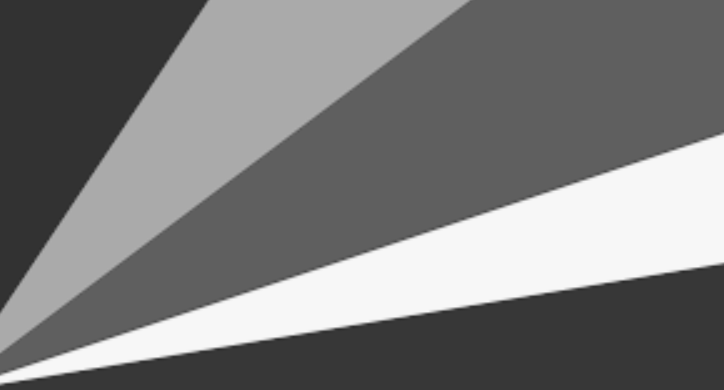

In [ ]:
##### CPU #####

import matplotlib.pyplot as plt
from PIL import Image
from IPython.display import display
import numpy as np
from numba import cuda
import time

image = Image.open('/content/image.PNG')

start_time = time.time() # Timer

rgb_array = np.array(image)
grey_array = np.zeros((rgb_array.shape[0], rgb_array.shape[1]), dtype=np.uint8) # Allocate space for the result

width, height = grey_array.shape[0], grey_array.shape[1] # Shape of the image

for x in range(width):
    for y in range(height):
        r = rgb_array[x, y, 0]
        g = rgb_array[x, y, 1]
        b = rgb_array[x, y, 2]
        grey_array[x, y] = int((float(r) + float(g) + float(b)) / 3)  # Average of the 3 pîxels -> grey

end_time = time.time() # Timer
print(f"Time taken : {end_time - start_time} sec")

grey_img = Image.fromarray(grey_array)
display(grey_img) # Showing the result

Block size = 1  ->  Time taken = 0.072486 sec
Block size = 4  ->  Time taken = 0.000708 sec
Block size = 16  ->  Time taken = 0.000238 sec
Block size = 32  ->  Time taken = 0.000137 sec
Block size = 64  ->  Time taken = 0.000126 sec
Block size = 128  ->  Time taken = 0.000123 sec
Block size = 256  ->  Time taken = 0.000134 sec
Block size = 512  ->  Time taken = 0.000134 sec
Block size = 1024  ->  Time taken = 0.000130 sec


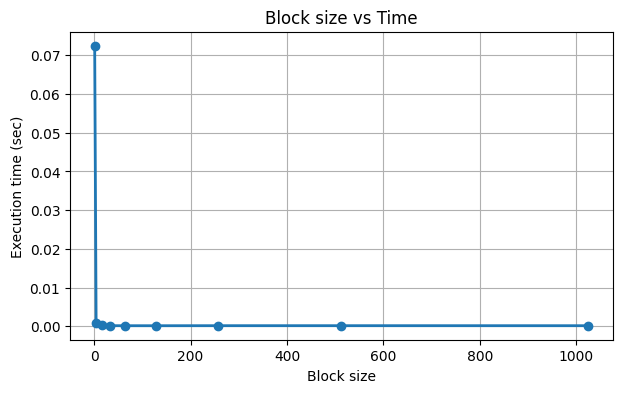

In [8]:
#### GPU Blocks & Graph ####

from PIL import Image
import time
import numpy as np
from numba import cuda, config
import matplotlib.pyplot as plt
config.CUDA_ENABLE_PYNVJITLINK = 1

# Function to convert in a grey image
@cuda.jit   # For GPU
def greyscale_gpu(src, dst):
    tidx = cuda.grid(1)
    if tidx < src.shape[0]: # Image limit
        r = src[tidx, 0]
        g = src[tidx, 1]
        b = src[tidx, 2]
        gy = np.uint8((r + g + b) / 3)  # Average of pixels
        dst[tidx, 0] = gy
        dst[tidx, 1] = gy
        dst[tidx, 2] = gy # The 3 pixels become grey

img = Image.open("/content/image.PNG").convert("RGB") # Load image
rgb_array = np.array(img, dtype=np.uint8)
h, w, c = rgb_array.shape
pixelCount = h * w
flat_img = rgb_array.reshape(pixelCount, 3) # 1D array

block_sizes = [1, 4, 16, 32, 64, 128, 256, 512, 1024] # Different block size values
times = [] # Timer

d_src = cuda.to_device(flat_img)   # Input
d_dst = cuda.device_array_like(flat_img)  # Output

# The Loop
for threads_per_block in block_sizes:
    blocks = (pixelCount + threads_per_block - 1) // threads_per_block

    start_time = time.time() # Timer
    greyscale_gpu[blocks, threads_per_block](d_src, d_dst) # Function for greyscaling
    cuda.synchronize()
    end_time = time.time()

    time_ = end_time - start_time # Timer
    times.append(time_)
    print(f"Block size = {threads_per_block}  ->  Time taken = {time_:.6f} sec")

# Graph
plt.figure(figsize=(7,4))
plt.plot(block_sizes, times, marker='o', linestyle='-', linewidth=2)
plt.xlabel('Block size')
plt.ylabel('Execution time (sec)')
plt.title('Block size vs Time')
plt.grid(True)
plt.show()